## Tumor microenvironment (TME) spatial niche analysis

Here we will use 10X Xenium breast cancer dataset as an example to illustrate how Garfield performs spatial niche analysis and niche characterization. Data access: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast.

### Load packages

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/pri_exthome/zhouwg/project/Garfield')
os.getcwd()

'/pri_exthome/zhouwg/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scipy.sparse as sp
import scanpy as sc

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'1.0.0'

### Read data

In [3]:
file_fold = '/pri_exthome/zhouwg/project/spatial_data/gold'
adata_batch1 = sc.read_h5ad(file_fold + '/xenium_human_breast_cancer_batch1.h5ad')
adata_batch1.X = adata_batch1.layers['counts'].copy()
adata_batch1.var_names_make_unique()
adata_batch2 = sc.read_h5ad(file_fold + '/xenium_human_breast_cancer_batch2.h5ad')
adata_batch2.X = adata_batch2.layers['counts'].copy()
adata_batch2.var_names_make_unique()

# concat
adata = adata_batch1.concatenate(adata_batch2, batch_key='batch')

# Create new adata to drop all unnecessary columns
adata_new = sc.AnnData(sp.csr_matrix(
    (adata.shape[0], adata.shape[1]),
    dtype=np.float32))
adata_new.X = adata.layers['counts'].copy()
adata_new.var_names = adata.var_names
adata_new.obs_names = adata.obs_names
adata_new.obsm["spatial"] = adata.obsm["spatial"]
adata_new.obs["cell_id"] = adata.obs["cell_id"].values
adata_new.obs["batch"] = adata.obs["batch"].values
adata_new.obs["replicates"] = adata.obs["replicates"].values

# Store raw counts in adata.layers
adata_new.layers["counts"] = adata.X.copy()
adata_new

AnnData object with n_obs × n_vars = 282363 × 313
    obs: 'cell_id', 'batch', 'replicates'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
adata_new.obs['replicates'].value_counts()

replicates
Rep_1    164000
Rep_2    118363
Name: count, dtype: int64

In [5]:
# Ensure adata.X is counts.
adata.X.max()

167.0

### Integrating spatially resolved transcriptomics data using Garfield

In [6]:
# set workdir #
workdir = '/pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast'
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=adata_new,
    profile='spatial',
    data_type='single-modal',
    sample_col='batch',
    weight=0.5,
    ## Preprocessing options
    graph_const_method='Squidpy', # mu_std, Radius, KNN, Squidpy
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    n_components=50,
    n_neighbors=5,
    metric='euclidean',
    svd_solver='arpack',
    # datasets
    used_pca_feat=False,
    adj_key='connectivities',
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,
    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=True,
    conv_type='GAT', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2,
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=True,
    used_DSBN=False,
    used_mmd=True,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=1., #
    lambda_edge_recon=1., #
    lambda_latent_adj_recon_loss=2.,
    lambda_omics_recon_mmd_loss=0.2,
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    device_id=0,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast


In [24]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [25]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Using GPU: device-0
Number of training nodes: 254127
Number of validation nodes: 28236
Number of training edges: 1615698
Number of validation edges: 179521
Edge batch size: 4096
Node batch size: 256

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8776; val_auprc_score: 0.8936; val_best_acc_score: 0.8172; val_best_f1_score: 0.8096; train_kl_reg_loss: 50.7585; train_edge_recon_loss: 1058.6235; train_gene_expr_recon_loss: 46871.5648; train_lambda_latent_adj_recon_loss: 1209.4891; train_lambda_latent_contrastive_instanceloss: 7.3723; train_lambda_latent_contrastive_clusterloss: 3.0528; train_gene_expr_mmd_loss: 17.7750; train_global_loss: 49218.6358; train_optim_loss: 49218.6358; val_kl_reg_loss: 46.5657; val_edge_recon_loss: 964.0532; val_gene_expr_recon_loss: 41828.2551; val_lambda_latent_adj_recon_loss: 353.4837; val_lambda_latent_contrastive_instanceloss: 7.0974; val_lambda_latent_contrastive_clusterloss: 2.4568; val_gene

In [26]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [27]:
# Compute latent Leiden clustering
latent_leiden_resolution = 0.8
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
latent_key = "garfield_latent"

sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
len(model.adata.obs[latent_cluster_key].unique())

12

### Visualize Garfield Latent Space

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'latent_leiden_0.5'}, xlabel='UMAP1', ylabel='UMAP2'>]

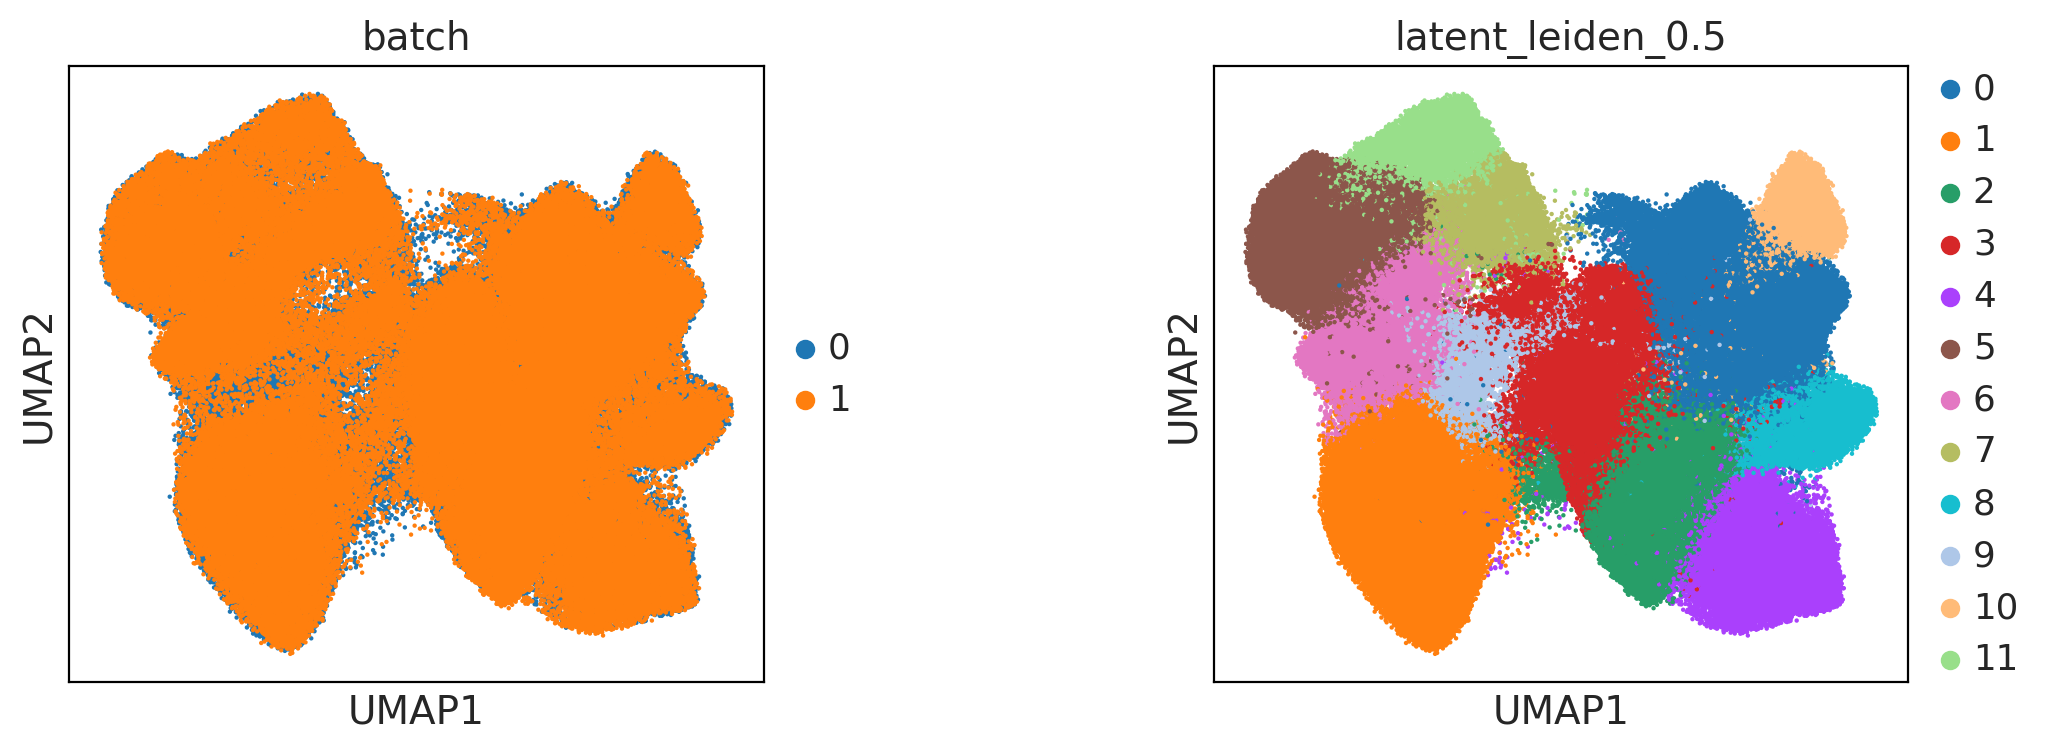

In [29]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

sc.pl.umap(model.adata, color=['replicates', latent_cluster_key],
           s=10, show=False, ncols=2, wspace=0.5) # , legend_loc='on data'

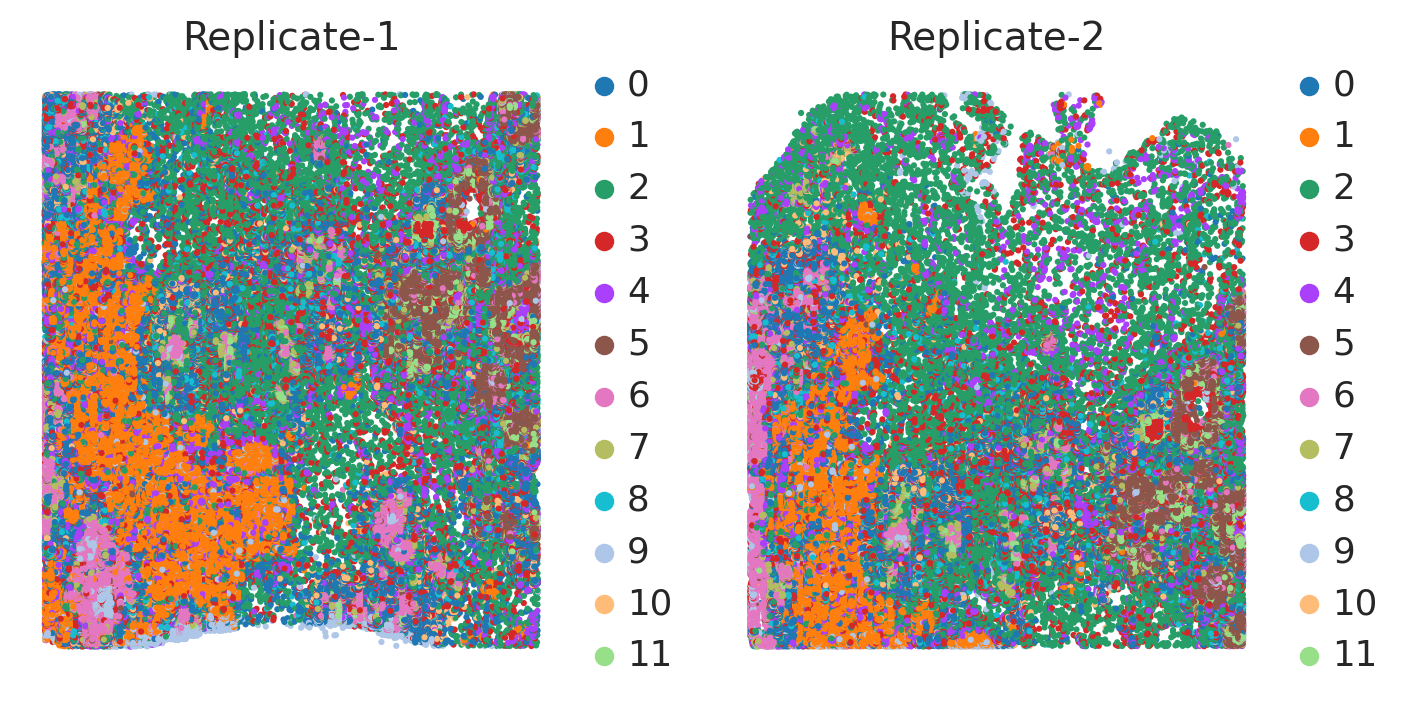

In [32]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'wspace': 0.3, 'hspace': 0.2})

sc.pl.embedding(model.adata[model.adata.obs['replicates'] == 'Rep_1'],
                basis='spatial', color=latent_cluster_key,
                title='Replicate-1', s=20, show=False,
                ax=ax[0], frameon=False)
sc.pl.embedding(model.adata[model.adata.obs['replicates'] == 'Rep_2'],
                basis='spatial', color=latent_cluster_key,
                title='Replicate-2', s=20, show=False,
                ax=ax[1], frameon=False)
plt.tight_layout(w_pad=0.3)

### Save model results

In [21]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_concat.h5ad")

Model saved successfully using pickle at /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast/model/attr.pkl


In [3]:
from Garfield.model import Garfield

workdir = f'/pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast'
gf.settings.set_workdir(workdir)
model_folder_path = f"{workdir}/model"

model = Garfield.load(dir_path=model_folder_path,
              adata_file_name="adata_concat.h5ad")

Saving results in: /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast
Model loaded successfully using pickle from /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_xenium_human_breast/model/attr.pkl
AnnData object with n_obs × n_vars = 282363 × 313
    obs: 'cell_id', 'batch', 'replicates', 'n_genes', 'latent_leiden_0.5', 'latent_leiden_0.4', 'latent_leiden_0.6', 'latent_leiden_0.7', 'latent_leiden_0.8', 'Cluster'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'batch_colors', 'garfield_latent', 'hvg', 'latent_leiden_0.4', 'latent_leiden_0.5', 'latent_leiden_0.5_colors', 'latent_leiden_0.6', 'latent_leiden_0.7', 'latent_leiden_0.8', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'feat', 'garfield_latent', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'norm_data'
    obsp: 'connectivitie

### Load original celltype labels

In [4]:
import pandas as pd

# 读取xlsx文件
root_dir = '/pri_exthome/zhouwg/project/spatial_data/bronze/xenium_human_breast_cancer'
data1 = pd.read_excel(os.path.join(root_dir, 'Cell_Barcode_Type_Matrices.xlsx'),
                     sheet_name='Xenium R1 Fig1-5 (supervised)', index_col=0)
# 生成新的行名
data1.index = [f"{name}-Rep_1-0" for name in data1.index]

data2 = pd.read_excel(os.path.join(root_dir, 'Cell_Barcode_Type_Matrices.xlsx'),
                     sheet_name='Xenium R2 Fig1-5 (supervised)', index_col=0)
# 生成新的行名
data2.index = [f"{name}-Rep_2-1" for name in data2.index]
data = pd.concat([data1, data2])

In [5]:
model.adata.obs['Cluster'].value_counts()

Cluster
Stromal                    80059
Invasive_Tumor             50133
DCIS_2                     21707
DCIS_1                     20094
Macrophages_1              19226
Endothelial                15630
CD4+_T_Cells               14393
Myoepi_ACTA2+              13140
CD8+_T_Cells               11888
B_Cells                     8779
Unlabeled                   7869
Prolif_Invasive_Tumor       5626
Myoepi_KRT15+               5507
Macrophages_2               3202
Perivascular-Like           1396
Stromal_&_T_Cell_Hybrid     1151
IRF7+_DCs                    894
T_Cell_&_Tumor_Hybrid        837
LAMP3+_DCs                   504
Mast_Cells                   328
Name: count, dtype: int64

<Axes: title={'center': 'Cluster'}, xlabel='UMAP1', ylabel='UMAP2'>

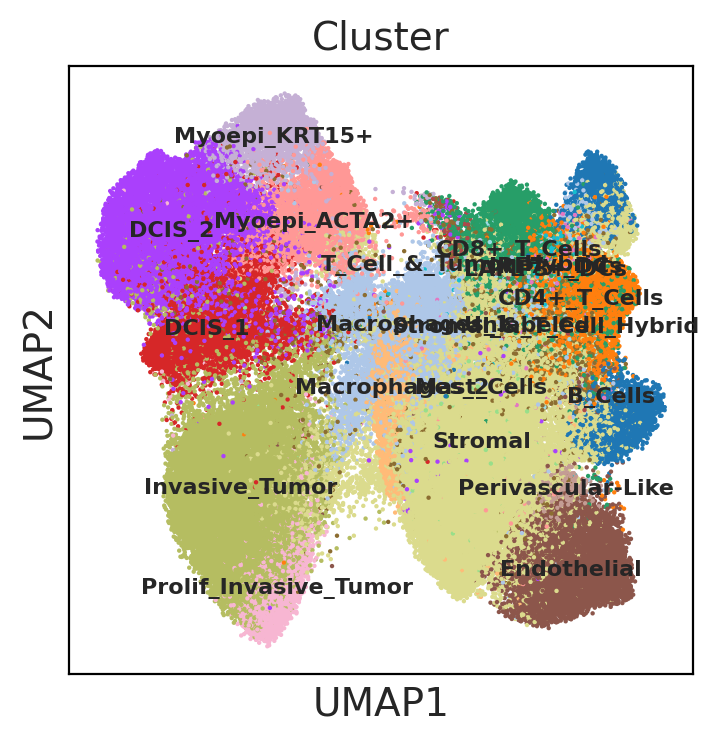

In [6]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

sc.pl.umap(model.adata[model.adata.obs['replicates'].isin(['Rep_2']), :],
           color=['Cluster'], s=10, show=False, ncols=2, legend_fontsize=8,
           wspace=0.3, legend_loc='on data')

In [7]:
### dendrogram analysis
sc.tl.dendrogram(adata=model.adata,
                 use_rep="garfield_latent",
                 linkage_method="single",
                 groupby="latent_leiden_0.8")

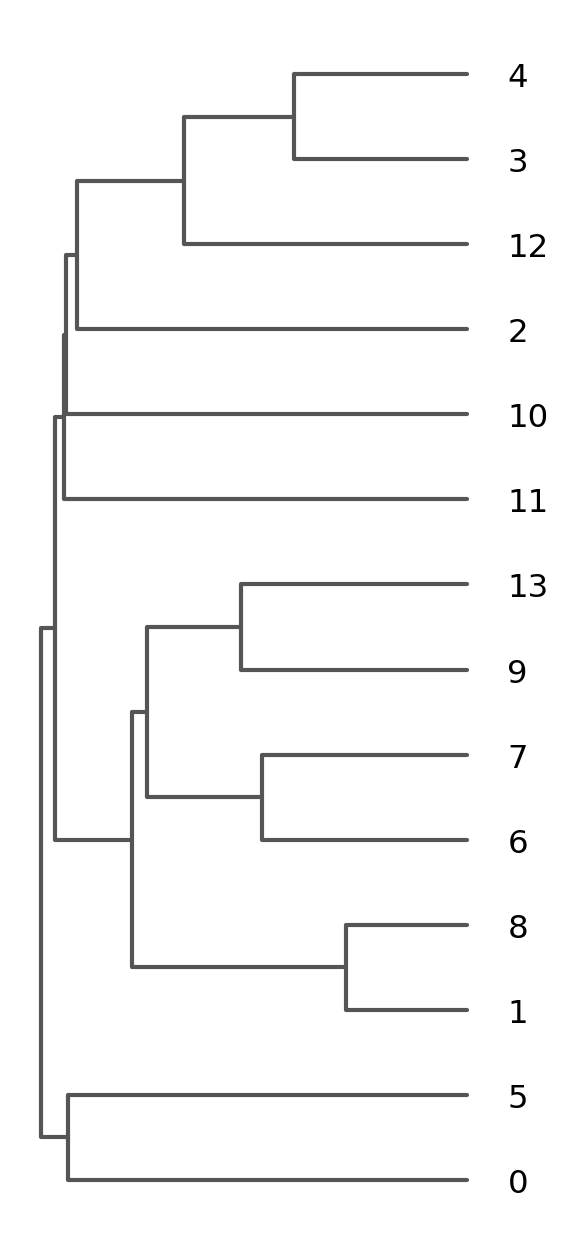

<Axes: >

In [8]:
from matplotlib import pyplot as plt
import matplotlib

fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
sc.pl.dendrogram(
    adata=model.adata,
    groupby="latent_leiden_0.8",
    orientation="left",
    ax=ax)

### Niche characterization

In [10]:
# Visualize the distribution of multiple cell types in space
from Garfield.analysis import calc_neighbor_prop

## Rep_1
n = 25  # 每个细胞计算的邻居数
batch_key = 'replicates'  # 用于区分批次的列
celltye_key = 'Cluster'   # 用于表示细胞类型的列

adata = model.adata.copy() 
adata = adata[adata.obs[batch_key] == 'Rep_1']

adata = calc_neighbor_prop(
    adata,
    batch_key='replicates',
    celltype_key='Cluster',
    n_neighbors=25,
    spatial_key='spatial',
    output_key=None
)

/home/zhouwg/project/Garfield/Garfield/plot/spatial_plot.py:372: RuntimeWarning: invalid value encountered in divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(


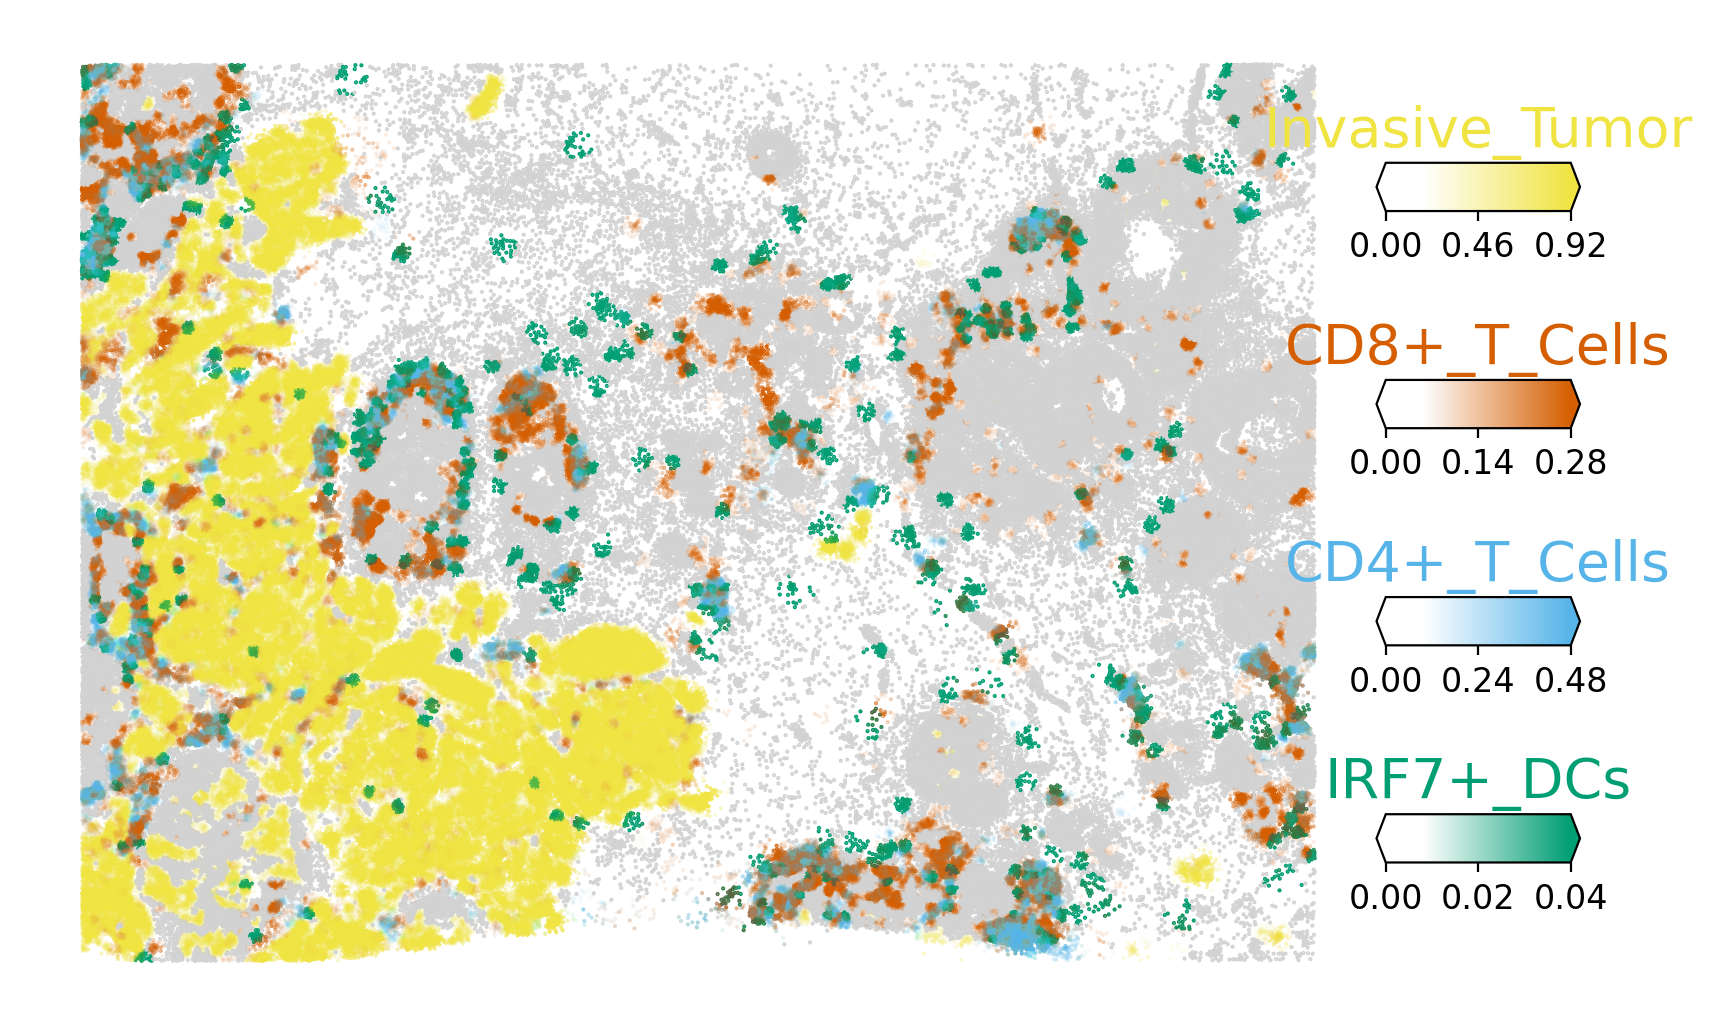

In [11]:
from matplotlib import rcParams
from Garfield.plot import plot_multi_patterns_spatial
rcParams['axes.grid'] = False
sc.settings.set_figure_params(dpi=100, facecolor='white')

# select cell types for visualization
select_celltype = ['CD8+_T_Cells', 'CD4+_T_Cells', 'Invasive_Tumor', 'IRF7+_DCs']

# obtain the celltype proportion
prop = adata.obsm[f'k{n}_neighbours_celltype_normalized']
prop_sub = prop.loc[:, prop.columns.isin(select_celltype)]

fig = plot_multi_patterns_spatial(
    adata,
    prop_sub,
    basis="spatial",
    display_zeros=True,
    spot_size=2)

### Niche functional enrichment analysis

In [12]:
from Garfield.analysis import calc_marker_stats,filter_marker_stats,aggregate_top_markers

niche_key = 'latent_leiden_0.8'
frac_df, mean_df, stats_df = calc_marker_stats(model.adata,
                                               groupby=niche_key,
                                               use_raw=False)

In [13]:
filtered_stats_df = filter_marker_stats(stats_df, use_raw=False)
filtered_stats_df

top_frac_group  top_frac  frac_diff  max_frac_diff top_mean_group  \
LUM                   0  0.996524   0.089779       0.157525              0   
POSTN                 0  0.981910   0.173626       0.211133              0   
CXCL12                0  0.921449   0.116930       0.134596              0   
CCDC80                0  0.942203   0.189961       0.316198              0   
MMP2                  0  0.900898   0.343140       0.374988              0   
...                 ...       ...        ...            ...            ...   
CDC42EP1             13  0.340711   0.144270       0.214085             13   
C5orf46              13  0.258892   0.074330       0.228083             13   
LIF                  13  0.137994   0.092833       0.113404             13   
TUBB2B               13  0.330179   0.064643       0.079973             13   
CXCL16               13  0.562815   0.088826       0.231686             13   

           top_mean  mean_diff  max_mean_diff  
LUM       23.035275  14.295960      15.823607  
POSTN     19.802172  13.911303      13.971071  
CXCL12    10.290223   6.076733       6.093116  
CCDC80     9.114605   5.254186       6.262940  
MMP2       5.896849   4.210658       4.382273  
...             ...        ...            ...  
CDC42EP1   0.482519   0.256816       0.341248  
C5orf46    0.470308   0.179277       0.432408  
LIF        0.231109   0.167806       0.200844  
TUBB2B     0.487557   0.148570       0.178164  
CXCL16     0.988393   0.142197       0.533212  

[215 rows x 8 columns]

In [14]:
final_markers = aggregate_top_markers(model.adata, filtered_stats_df,
                      groupby=niche_key, n_genes=100, use_raw=False)
final_markers

genes cluster  top_frac  frac_diff  max_frac_diff top_mean_group  \
0         LUM       0  0.996524   0.089779       0.157525              0   
1       POSTN       0  0.981910   0.173626       0.211133              0   
2      CXCL12       0  0.921449   0.116930       0.134596              0   
3      CCDC80       0  0.942203   0.189961       0.316198              0   
4        MMP2       0  0.900898   0.343140       0.374988              0   
..        ...     ...       ...        ...            ...            ...   
210  CDC42EP1      13  0.340711   0.144270       0.214085             13   
211   C5orf46      13  0.258892   0.074330       0.228083             13   
212       LIF      13  0.137994   0.092833       0.113404             13   
213    TUBB2B      13  0.330179   0.064643       0.079973             13   
214    CXCL16      13  0.562815   0.088826       0.231686             13   

      top_mean  mean_diff  max_mean_diff  logfoldchanges          pvals  \
0    23.035275  14.295960      15.823607       28.016331   0.000000e+00   
1    19.802172  13.911303      13.971071       24.424164   0.000000e+00   
2    10.290223   6.076733       6.093116       12.798749   0.000000e+00   
3     9.114605   5.254186       6.262940       11.820065   0.000000e+00   
4     5.896849   4.210658       4.382273        8.532184   0.000000e+00   
..         ...        ...            ...             ...            ...   
210   0.482519   0.256816       0.341248        2.660414  1.326514e-307   
211   0.470308   0.179277       0.432408        4.358301  5.843159e-235   
212   0.231109   0.167806       0.200844        3.344476  3.511281e-101   
213   0.487557   0.148570       0.178164        2.013302  4.539250e-213   
214   0.988393   0.142197       0.533212        2.198404   0.000000e+00   

         pvals_adj  
0     0.000000e+00  
1     0.000000e+00  
2     0.000000e+00  
3     0.000000e+00  
4     0.000000e+00  
..             ...  
210  3.204500e-307  
211  1.243841e-234  
212  5.066613e-101  
213  9.036470e-213  
214   0.000000e+00  

[215 rows x 12 columns]

In [15]:
# enrichment
from Garfield.analysis import get_enrichr_geneset,get_niche_enrichr,get_fast_niche_enrichr

get_enrichr_geneset(organism="Human")

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [16]:
## KEGG analysis
enrich_dict = get_niche_enrichr(final_markers, geneset='KEGG_2019_Human',
                                niche_column='cluster', niches="all",
                                organism="human", topn_genes=200)
enrich_dict

{'0':            Gene_set                                     Term Overlap  \
 0   KEGG_2019_Human                                 Melanoma    3/72   
 1   KEGG_2019_Human                                   Glioma    3/75   
 2   KEGG_2019_Human                          Prostate cancer    3/97   
 3   KEGG_2019_Human                       Pathways in cancer   5/530   
 4   KEGG_2019_Human                  Ovarian steroidogenesis    2/49   
 ..              ...                                      ...     ...   
 68  KEGG_2019_Human              Chemokine signaling pathway   1/190   
 69  KEGG_2019_Human                              Endocytosis   1/244   
 70  KEGG_2019_Human   Cytokine-cytokine receptor interaction   1/294   
 71  KEGG_2019_Human           Human papillomavirus infection   1/330   
 72  KEGG_2019_Human  Neuroactive ligand-receptor interaction   1/338   
 
      P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
 0   0.000123          0.005068    

In [17]:
## GO analysis
enrich_dict = get_niche_enrichr(final_markers, geneset='GO_Biological_Process_2023',
                                niche_column='cluster', niches="all",
                                organism="human", topn_genes=200)
enrich_dict

{'0':                        Gene_set  \
 0    GO_Biological_Process_2023   
 1    GO_Biological_Process_2023   
 2    GO_Biological_Process_2023   
 3    GO_Biological_Process_2023   
 4    GO_Biological_Process_2023   
 ..                          ...   
 472  GO_Biological_Process_2023   
 473  GO_Biological_Process_2023   
 474  GO_Biological_Process_2023   
 475  GO_Biological_Process_2023   
 476  GO_Biological_Process_2023   
 
                                                   Term Overlap       P-value  \
 0    Positive Regulation Of Cellular Metabolic Proc...    4/56  9.218820e-07   
 1       Extracellular Matrix Organization (GO:0030198)   5/176  3.439735e-06   
 2           Diterpenoid Metabolic Process (GO:0016101)    3/28  7.027351e-06   
 3    Positive Regulation Of Cell Motility (GO:2000147)   5/221  1.042434e-05   
 4       Inositol Lipid-Mediated Signaling (GO:0048017)    3/33  1.165118e-05   
 ..                                                 ...     ...           .